In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_1:cores",
    "device": "cuda",
    "lr": 0.0001,
    "labels": [
        "1-10.",
        "1-11.",
        "1-15.",
        "1-16.",
        "1-17.",
        "1-18.",
        "1-19.",
        "10-4.",
        "10-7.",
        "11-1.",
        "11-14.",
        "11-17.",
        "11-20.",
        "11-7.",
        "13-20.",
        "13-8.",
        "14-10.",
        "14-11.",
        "14-14.",
        "14-7.",
        "15-1.",
        "15-20.",
        "16-1.",
        "16-16.",
        "17-10.",
        "17-11.",
        "17-2.",
        "19-1.",
        "19-16.",
        "19-19.",
        "19-20.",
        "19-3.",
        "2-10.",
        "2-11.",
        "2-17.",
        "2-18.",
        "2-20.",
        "2-3.",
        "2-4.",
        "2-5.",
        "2-6.",
        "2-7.",
        "2-8.",
        "3-13.",
        "3-18.",
        "3-3.",
        "4-1.",
        "4-10.",
        "4-11.",
        "4-19.",
        "5-5.",
        "6-15.",
        "7-10.",
        "7-14.",
        "8-18.",
        "8-20.",
        "8-3.",
        "8-8.",
    ],
    "batch_size": 128,
    "domains_source": [1, 5],
    "domains_target": [2, 3, 4],
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 58}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name_source": "cores.stratified_ds.2022A.pkl",
    "pickle_name_target": "cores.stratified_ds.2022A.pkl",
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 568], examples_per_second: 621.3683, train_label_loss: 4.0176, 


epoch: 1, [batch: 57 / 568], examples_per_second: 10306.9097, train_label_loss: 2.7713, 


epoch: 1, [batch: 114 / 568], examples_per_second: 10739.3513, train_label_loss: 1.8883, 


epoch: 1, [batch: 171 / 568], examples_per_second: 10773.6745, train_label_loss: 1.3210, 


epoch: 1, [batch: 227 / 568], examples_per_second: 10742.7013, train_label_loss: 0.8738, 


epoch: 1, [batch: 284 / 568], examples_per_second: 10736.5480, train_label_loss: 0.7364, 


epoch: 1, [batch: 341 / 568], examples_per_second: 10763.2993, train_label_loss: 0.5228, 


epoch: 1, [batch: 397 / 568], examples_per_second: 10613.8765, train_label_loss: 0.3696, 


epoch: 1, [batch: 454 / 568], examples_per_second: 10555.7337, train_label_loss: 0.3168, 


epoch: 1, [batch: 511 / 568], examples_per_second: 10721.4339, train_label_loss: 0.2801, 


epoch: 1, source_val_acc_label: 0.9738, source_val_label_loss: 0.2359, target_val_acc_label: 0.8257, target_val_label_loss: 0.7840, 


New best
epoch: 2, [batch: 1 / 568], examples_per_second: 101.0031, train_label_loss: 0.2564, 


epoch: 2, [batch: 57 / 568], examples_per_second: 10335.0738, train_label_loss: 0.1822, 


epoch: 2, [batch: 114 / 568], examples_per_second: 10696.5537, train_label_loss: 0.1110, 


epoch: 2, [batch: 171 / 568], examples_per_second: 10793.0346, train_label_loss: 0.1425, 


epoch: 2, [batch: 227 / 568], examples_per_second: 10833.0860, train_label_loss: 0.0828, 


epoch: 2, [batch: 284 / 568], examples_per_second: 10582.5345, train_label_loss: 0.1177, 


epoch: 2, [batch: 341 / 568], examples_per_second: 10779.9024, train_label_loss: 0.1178, 


epoch: 2, [batch: 397 / 568], examples_per_second: 10745.2508, train_label_loss: 0.0857, 


epoch: 2, [batch: 454 / 568], examples_per_second: 10668.6411, train_label_loss: 0.0549, 


epoch: 2, [batch: 511 / 568], examples_per_second: 10714.4255, train_label_loss: 0.0638, 


epoch: 2, source_val_acc_label: 0.9215, source_val_label_loss: 0.3541, target_val_acc_label: 0.7708, target_val_label_loss: 0.8886, 


epoch: 3, [batch: 1 / 568], examples_per_second: 121.2871, train_label_loss: 0.3716, 


epoch: 3, [batch: 57 / 568], examples_per_second: 10540.0816, train_label_loss: 0.2447, 


epoch: 3, [batch: 114 / 568], examples_per_second: 10723.4101, train_label_loss: 0.1763, 


epoch: 3, [batch: 171 / 568], examples_per_second: 10571.1690, train_label_loss: 0.0753, 


epoch: 3, [batch: 227 / 568], examples_per_second: 10784.8330, train_label_loss: 0.0786, 


epoch: 3, [batch: 284 / 568], examples_per_second: 10914.8088, train_label_loss: 0.0894, 


epoch: 3, [batch: 341 / 568], examples_per_second: 10375.8543, train_label_loss: 0.0448, 


epoch: 3, [batch: 397 / 568], examples_per_second: 10736.5248, train_label_loss: 0.0475, 


epoch: 3, [batch: 454 / 568], examples_per_second: 10637.2305, train_label_loss: 0.0539, 


epoch: 3, [batch: 511 / 568], examples_per_second: 10705.5645, train_label_loss: 0.0326, 


epoch: 3, source_val_acc_label: 0.9934, source_val_label_loss: 0.0548, target_val_acc_label: 0.8482, target_val_label_loss: 0.5771, 


New best
epoch: 4, [batch: 1 / 568], examples_per_second: 121.9118, train_label_loss: 0.0382, 


epoch: 4, [batch: 57 / 568], examples_per_second: 10774.4632, train_label_loss: 0.0406, 


epoch: 4, [batch: 114 / 568], examples_per_second: 10645.1972, train_label_loss: 0.0280, 


epoch: 4, [batch: 171 / 568], examples_per_second: 10782.3979, train_label_loss: 0.0337, 


epoch: 4, [batch: 227 / 568], examples_per_second: 10692.8253, train_label_loss: 0.0284, 


epoch: 4, [batch: 284 / 568], examples_per_second: 10411.6399, train_label_loss: 0.0415, 


epoch: 4, [batch: 341 / 568], examples_per_second: 10184.3779, train_label_loss: 0.0301, 


epoch: 4, [batch: 397 / 568], examples_per_second: 10463.1237, train_label_loss: 0.0203, 


epoch: 4, [batch: 454 / 568], examples_per_second: 10668.5183, train_label_loss: 0.0191, 


epoch: 4, [batch: 511 / 568], examples_per_second: 10669.4222, train_label_loss: 0.0456, 


epoch: 4, source_val_acc_label: 0.9954, source_val_label_loss: 0.0290, target_val_acc_label: 0.8509, target_val_label_loss: 0.6077, 


New best
epoch: 5, [batch: 1 / 568], examples_per_second: 121.8764, train_label_loss: 0.0214, 


epoch: 5, [batch: 57 / 568], examples_per_second: 10622.4942, train_label_loss: 0.0221, 


epoch: 5, [batch: 114 / 568], examples_per_second: 10466.0572, train_label_loss: 0.0079, 


epoch: 5, [batch: 171 / 568], examples_per_second: 10623.9323, train_label_loss: 0.0099, 


epoch: 5, [batch: 227 / 568], examples_per_second: 10783.7073, train_label_loss: 0.0108, 


epoch: 5, [batch: 284 / 568], examples_per_second: 10495.4232, train_label_loss: 0.0140, 


epoch: 5, [batch: 341 / 568], examples_per_second: 10777.2145, train_label_loss: 0.0072, 


epoch: 5, [batch: 397 / 568], examples_per_second: 11931.2601, train_label_loss: 0.0120, 


epoch: 5, [batch: 454 / 568], examples_per_second: 11677.6136, train_label_loss: 0.0173, 


epoch: 5, [batch: 511 / 568], examples_per_second: 11765.0884, train_label_loss: 0.0127, 


epoch: 5, source_val_acc_label: 0.9934, source_val_label_loss: 0.0293, target_val_acc_label: 0.8552, target_val_label_loss: 0.5313, 


New best
epoch: 6, [batch: 1 / 568], examples_per_second: 133.6419, train_label_loss: 0.0628, 


epoch: 6, [batch: 57 / 568], examples_per_second: 11606.2093, train_label_loss: 0.0469, 


epoch: 6, [batch: 114 / 568], examples_per_second: 11768.1695, train_label_loss: 0.0402, 


epoch: 6, [batch: 171 / 568], examples_per_second: 11735.6259, train_label_loss: 0.0201, 


epoch: 6, [batch: 227 / 568], examples_per_second: 11738.8375, train_label_loss: 0.0220, 


epoch: 6, [batch: 284 / 568], examples_per_second: 11798.4190, train_label_loss: 0.0220, 


epoch: 6, [batch: 341 / 568], examples_per_second: 11726.2811, train_label_loss: 0.0340, 


epoch: 6, [batch: 397 / 568], examples_per_second: 11730.6389, train_label_loss: 0.0251, 


epoch: 6, [batch: 454 / 568], examples_per_second: 11740.4345, train_label_loss: 0.0119, 


epoch: 6, [batch: 511 / 568], examples_per_second: 11968.3996, train_label_loss: 0.0165, 


epoch: 6, source_val_acc_label: 0.9961, source_val_label_loss: 0.0214, target_val_acc_label: 0.8479, target_val_label_loss: 0.5592, 


epoch: 7, [batch: 1 / 568], examples_per_second: 137.5986, train_label_loss: 0.0095, 


epoch: 7, [batch: 57 / 568], examples_per_second: 11718.7963, train_label_loss: 0.0069, 


epoch: 7, [batch: 114 / 568], examples_per_second: 11833.9568, train_label_loss: 0.0040, 


epoch: 7, [batch: 171 / 568], examples_per_second: 11788.4291, train_label_loss: 0.0103, 


epoch: 7, [batch: 227 / 568], examples_per_second: 12603.1372, train_label_loss: 0.0234, 


epoch: 7, [batch: 284 / 568], examples_per_second: 11904.9607, train_label_loss: 0.0137, 


epoch: 7, [batch: 341 / 568], examples_per_second: 11758.3708, train_label_loss: 0.0104, 


epoch: 7, [batch: 397 / 568], examples_per_second: 11759.4073, train_label_loss: 0.0039, 


epoch: 7, [batch: 454 / 568], examples_per_second: 11818.7647, train_label_loss: 0.0191, 


epoch: 7, [batch: 511 / 568], examples_per_second: 11790.6002, train_label_loss: 0.0055, 


epoch: 7, source_val_acc_label: 0.9966, source_val_label_loss: 0.0150, target_val_acc_label: 0.8549, target_val_label_loss: 0.5736, 


epoch: 8, [batch: 1 / 568], examples_per_second: 138.6888, train_label_loss: 0.0048, 


epoch: 8, [batch: 57 / 568], examples_per_second: 11750.0823, train_label_loss: 0.0041, 


epoch: 8, [batch: 114 / 568], examples_per_second: 11860.6280, train_label_loss: 0.0100, 


epoch: 8, [batch: 171 / 568], examples_per_second: 11681.2466, train_label_loss: 0.0041, 


epoch: 8, [batch: 227 / 568], examples_per_second: 11797.5503, train_label_loss: 0.0033, 


epoch: 8, [batch: 284 / 568], examples_per_second: 11682.2767, train_label_loss: 0.0027, 


epoch: 8, [batch: 341 / 568], examples_per_second: 11863.7732, train_label_loss: 0.0034, 


epoch: 8, [batch: 397 / 568], examples_per_second: 11834.3622, train_label_loss: 0.0026, 


epoch: 8, [batch: 454 / 568], examples_per_second: 11785.0287, train_label_loss: 0.0032, 


epoch: 8, [batch: 511 / 568], examples_per_second: 11797.1455, train_label_loss: 0.0038, 


epoch: 8, source_val_acc_label: 0.9913, source_val_label_loss: 0.0286, target_val_acc_label: 0.8413, target_val_label_loss: 0.6310, 


epoch: 9, [batch: 1 / 568], examples_per_second: 137.7770, train_label_loss: 0.0036, 


epoch: 9, [batch: 57 / 568], examples_per_second: 11750.1328, train_label_loss: 0.0032, 


epoch: 9, [batch: 114 / 568], examples_per_second: 11674.7267, train_label_loss: 0.0023, 


epoch: 9, [batch: 171 / 568], examples_per_second: 11759.4236, train_label_loss: 0.0044, 


epoch: 9, [batch: 227 / 568], examples_per_second: 11900.5952, train_label_loss: 0.0030, 


epoch: 9, [batch: 284 / 568], examples_per_second: 11739.1779, train_label_loss: 0.0029, 


epoch: 9, [batch: 341 / 568], examples_per_second: 11759.6721, train_label_loss: 0.0025, 


epoch: 9, [batch: 397 / 568], examples_per_second: 11884.0744, train_label_loss: 0.0062, 


epoch: 9, [batch: 454 / 568], examples_per_second: 11837.0695, train_label_loss: 0.0047, 


epoch: 9, [batch: 511 / 568], examples_per_second: 11780.0747, train_label_loss: 0.0034, 


epoch: 9, source_val_acc_label: 0.9950, source_val_label_loss: 0.0181, target_val_acc_label: 0.8556, target_val_label_loss: 0.5763, 


New best
epoch: 10, [batch: 1 / 568], examples_per_second: 136.7998, train_label_loss: 0.0026, 


epoch: 10, [batch: 57 / 568], examples_per_second: 11785.3968, train_label_loss: 0.0027, 


epoch: 10, [batch: 114 / 568], examples_per_second: 11772.8825, train_label_loss: 0.0099, 


epoch: 10, [batch: 171 / 568], examples_per_second: 11674.7891, train_label_loss: 0.0042, 


epoch: 10, [batch: 227 / 568], examples_per_second: 11860.2726, train_label_loss: 0.0029, 


epoch: 10, [batch: 284 / 568], examples_per_second: 12858.2001, train_label_loss: 0.0049, 


epoch: 10, [batch: 341 / 568], examples_per_second: 12036.5317, train_label_loss: 0.0034, 


epoch: 10, [batch: 397 / 568], examples_per_second: 12373.4591, train_label_loss: 0.0011, 


epoch: 10, [batch: 454 / 568], examples_per_second: 12463.9357, train_label_loss: 0.0013, 


epoch: 10, [batch: 511 / 568], examples_per_second: 10789.6591, train_label_loss: 0.0057, 


epoch: 10, source_val_acc_label: 0.9944, source_val_label_loss: 0.0214, target_val_acc_label: 0.8467, target_val_label_loss: 0.6483, 


epoch: 11, [batch: 1 / 568], examples_per_second: 121.3499, train_label_loss: 0.0029, 


epoch: 11, [batch: 57 / 568], examples_per_second: 10686.4515, train_label_loss: 0.0071, 


epoch: 11, [batch: 114 / 568], examples_per_second: 10620.4074, train_label_loss: 0.0017, 


epoch: 11, [batch: 171 / 568], examples_per_second: 11333.3118, train_label_loss: 0.0022, 


epoch: 11, [batch: 227 / 568], examples_per_second: 11786.3624, train_label_loss: 0.0018, 


epoch: 11, [batch: 284 / 568], examples_per_second: 11741.6687, train_label_loss: 0.0020, 


epoch: 11, [batch: 341 / 568], examples_per_second: 11718.0325, train_label_loss: 0.0016, 


epoch: 11, [batch: 397 / 568], examples_per_second: 11736.6745, train_label_loss: 0.0010, 


epoch: 11, [batch: 454 / 568], examples_per_second: 11816.3597, train_label_loss: 0.0024, 


epoch: 11, [batch: 511 / 568], examples_per_second: 11800.7394, train_label_loss: 0.0066, 


epoch: 11, source_val_acc_label: 0.8520, source_val_label_loss: 1.0767, target_val_acc_label: 0.6952, target_val_label_loss: 1.7980, 


epoch: 12, [batch: 1 / 568], examples_per_second: 139.9243, train_label_loss: 0.2184, 


epoch: 12, [batch: 57 / 568], examples_per_second: 11595.9179, train_label_loss: 0.0965, 


epoch: 12, [batch: 114 / 568], examples_per_second: 11722.1307, train_label_loss: 0.0499, 


epoch: 12, [batch: 171 / 568], examples_per_second: 11671.1468, train_label_loss: 0.0446, 


epoch: 12, [batch: 227 / 568], examples_per_second: 11747.4424, train_label_loss: 0.0271, 


epoch: 12, [batch: 284 / 568], examples_per_second: 11712.3367, train_label_loss: 0.0495, 


epoch: 12, [batch: 341 / 568], examples_per_second: 11815.5932, train_label_loss: 0.0086, 


epoch: 12, [batch: 397 / 568], examples_per_second: 11722.6391, train_label_loss: 0.0164, 


epoch: 12, [batch: 454 / 568], examples_per_second: 11720.0970, train_label_loss: 0.0146, 


epoch: 12, [batch: 511 / 568], examples_per_second: 11726.0475, train_label_loss: 0.0366, 


epoch: 12, source_val_acc_label: 0.9968, source_val_label_loss: 0.0215, target_val_acc_label: 0.8525, target_val_label_loss: 0.5949, 


epoch: 13, [batch: 1 / 568], examples_per_second: 142.1636, train_label_loss: 0.0077, 


epoch: 13, [batch: 57 / 568], examples_per_second: 12207.3537, train_label_loss: 0.0051, 


epoch: 13, [batch: 114 / 568], examples_per_second: 12308.1844, train_label_loss: 0.0118, 


epoch: 13, [batch: 171 / 568], examples_per_second: 11794.5856, train_label_loss: 0.0064, 


epoch: 13, [batch: 227 / 568], examples_per_second: 11782.7040, train_label_loss: 0.0082, 


epoch: 13, [batch: 284 / 568], examples_per_second: 11760.5172, train_label_loss: 0.0051, 


epoch: 13, [batch: 341 / 568], examples_per_second: 11779.8072, train_label_loss: 0.0031, 


epoch: 13, [batch: 397 / 568], examples_per_second: 11724.8426, train_label_loss: 0.0071, 


epoch: 13, [batch: 454 / 568], examples_per_second: 11812.1589, train_label_loss: 0.0045, 


epoch: 13, [batch: 511 / 568], examples_per_second: 11770.5640, train_label_loss: 0.0020, 


epoch: 13, source_val_acc_label: 0.9961, source_val_label_loss: 0.0179, target_val_acc_label: 0.8560, target_val_label_loss: 0.6097, 


New best
epoch: 14, [batch: 1 / 568], examples_per_second: 135.2306, train_label_loss: 0.0055, 


epoch: 14, [batch: 57 / 568], examples_per_second: 11547.5001, train_label_loss: 0.0047, 


epoch: 14, [batch: 114 / 568], examples_per_second: 11759.7128, train_label_loss: 0.0017, 


epoch: 14, [batch: 171 / 568], examples_per_second: 11802.3460, train_label_loss: 0.0013, 


epoch: 14, [batch: 227 / 568], examples_per_second: 11801.7044, train_label_loss: 0.0033, 


epoch: 14, [batch: 284 / 568], examples_per_second: 11826.9135, train_label_loss: 0.0016, 


epoch: 14, [batch: 341 / 568], examples_per_second: 11657.9105, train_label_loss: 0.0026, 


epoch: 14, [batch: 397 / 568], examples_per_second: 11928.5287, train_label_loss: 0.0022, 


epoch: 14, [batch: 454 / 568], examples_per_second: 11793.5537, train_label_loss: 0.0015, 


epoch: 14, [batch: 511 / 568], examples_per_second: 11854.2417, train_label_loss: 0.0019, 


epoch: 14, source_val_acc_label: 0.9963, source_val_label_loss: 0.0157, target_val_acc_label: 0.8606, target_val_label_loss: 0.6209, 


New best
epoch: 15, [batch: 1 / 568], examples_per_second: 134.6767, train_label_loss: 0.0013, 


epoch: 15, [batch: 57 / 568], examples_per_second: 11701.9106, train_label_loss: 0.0031, 


epoch: 15, [batch: 114 / 568], examples_per_second: 11892.9914, train_label_loss: 0.0068, 


epoch: 15, [batch: 171 / 568], examples_per_second: 11823.6737, train_label_loss: 0.0065, 


epoch: 15, [batch: 227 / 568], examples_per_second: 11711.6155, train_label_loss: 0.0019, 


epoch: 15, [batch: 284 / 568], examples_per_second: 11626.6179, train_label_loss: 0.0054, 


epoch: 15, [batch: 341 / 568], examples_per_second: 11730.7853, train_label_loss: 0.0035, 


epoch: 15, [batch: 397 / 568], examples_per_second: 11797.0272, train_label_loss: 0.0023, 


epoch: 15, [batch: 454 / 568], examples_per_second: 11726.3395, train_label_loss: 0.0019, 


epoch: 15, [batch: 511 / 568], examples_per_second: 11769.4413, train_label_loss: 0.0008, 


epoch: 15, source_val_acc_label: 0.9580, source_val_label_loss: 0.1595, target_val_acc_label: 0.8185, target_val_label_loss: 1.1174, 


epoch: 16, [batch: 1 / 568], examples_per_second: 138.6557, train_label_loss: 0.0917, 


epoch: 16, [batch: 57 / 568], examples_per_second: 12045.0118, train_label_loss: 0.0292, 


epoch: 16, [batch: 114 / 568], examples_per_second: 12638.2355, train_label_loss: 0.0358, 


epoch: 16, [batch: 171 / 568], examples_per_second: 12727.3613, train_label_loss: 0.0032, 


epoch: 16, [batch: 227 / 568], examples_per_second: 12609.6071, train_label_loss: 0.0044, 


epoch: 16, [batch: 284 / 568], examples_per_second: 12403.4596, train_label_loss: 0.0070, 


epoch: 16, [batch: 341 / 568], examples_per_second: 10856.9437, train_label_loss: 0.0083, 


epoch: 16, [batch: 397 / 568], examples_per_second: 10824.2948, train_label_loss: 0.0055, 


epoch: 16, [batch: 454 / 568], examples_per_second: 10704.9953, train_label_loss: 0.0288, 


epoch: 16, [batch: 511 / 568], examples_per_second: 10759.2349, train_label_loss: 0.0073, 


epoch: 16, source_val_acc_label: 0.9959, source_val_label_loss: 0.0193, target_val_acc_label: 0.8451, target_val_label_loss: 0.6801, 


epoch: 17, [batch: 1 / 568], examples_per_second: 122.3417, train_label_loss: 0.0037, 


epoch: 17, [batch: 57 / 568], examples_per_second: 10699.7818, train_label_loss: 0.0038, 


epoch: 17, [batch: 114 / 568], examples_per_second: 10634.1809, train_label_loss: 0.0078, 


epoch: 17, [batch: 171 / 568], examples_per_second: 10787.7763, train_label_loss: 0.0110, 


epoch: 17, [batch: 227 / 568], examples_per_second: 10858.8983, train_label_loss: 0.0034, 


epoch: 17, [batch: 284 / 568], examples_per_second: 10603.1232, train_label_loss: 0.0044, 


epoch: 17, [batch: 341 / 568], examples_per_second: 10777.7763, train_label_loss: 0.0042, 


epoch: 17, [batch: 397 / 568], examples_per_second: 10737.1613, train_label_loss: 0.0009, 


epoch: 17, [batch: 454 / 568], examples_per_second: 10657.6727, train_label_loss: 0.0034, 


epoch: 17, [batch: 511 / 568], examples_per_second: 10757.6842, train_label_loss: 0.0011, 


epoch: 17, source_val_acc_label: 0.9956, source_val_label_loss: 0.0201, target_val_acc_label: 0.8618, target_val_label_loss: 0.6316, 


New best
epoch: 18, [batch: 1 / 568], examples_per_second: 118.7055, train_label_loss: 0.0023, 


epoch: 18, [batch: 57 / 568], examples_per_second: 10534.9995, train_label_loss: 0.0037, 


epoch: 18, [batch: 114 / 568], examples_per_second: 10802.9066, train_label_loss: 0.0014, 


epoch: 18, [batch: 171 / 568], examples_per_second: 10839.6456, train_label_loss: 0.0018, 


epoch: 18, [batch: 227 / 568], examples_per_second: 10785.5371, train_label_loss: 0.0007, 


epoch: 18, [batch: 284 / 568], examples_per_second: 10783.9291, train_label_loss: 0.0006, 


epoch: 18, [batch: 341 / 568], examples_per_second: 10849.4377, train_label_loss: 0.0013, 


epoch: 18, [batch: 397 / 568], examples_per_second: 10787.2437, train_label_loss: 0.0016, 


epoch: 18, [batch: 454 / 568], examples_per_second: 10737.9759, train_label_loss: 0.0008, 


epoch: 18, [batch: 511 / 568], examples_per_second: 10737.7272, train_label_loss: 0.0009, 


epoch: 18, source_val_acc_label: 0.9500, source_val_label_loss: 0.2051, target_val_acc_label: 0.8050, target_val_label_loss: 1.1869, 


epoch: 19, [batch: 1 / 568], examples_per_second: 123.6162, train_label_loss: 0.0402, 


epoch: 19, [batch: 57 / 568], examples_per_second: 10706.8998, train_label_loss: 0.0342, 


epoch: 19, [batch: 114 / 568], examples_per_second: 10638.1956, train_label_loss: 0.0054, 


epoch: 19, [batch: 171 / 568], examples_per_second: 10801.7626, train_label_loss: 0.0294, 


epoch: 19, [batch: 227 / 568], examples_per_second: 10762.5026, train_label_loss: 0.0044, 


epoch: 19, [batch: 284 / 568], examples_per_second: 10593.0187, train_label_loss: 0.0124, 


epoch: 19, [batch: 341 / 568], examples_per_second: 10781.3190, train_label_loss: 0.0049, 


epoch: 19, [batch: 397 / 568], examples_per_second: 10728.2264, train_label_loss: 0.0013, 


epoch: 19, [batch: 454 / 568], examples_per_second: 10891.2718, train_label_loss: 0.0067, 


epoch: 19, [batch: 511 / 568], examples_per_second: 10809.0844, train_label_loss: 0.0080, 


epoch: 19, source_val_acc_label: 0.9876, source_val_label_loss: 0.0450, target_val_acc_label: 0.8364, target_val_label_loss: 0.7157, 


epoch: 20, [batch: 1 / 568], examples_per_second: 122.7048, train_label_loss: 0.0366, 


epoch: 20, [batch: 57 / 568], examples_per_second: 10741.6113, train_label_loss: 0.0057, 


epoch: 20, [batch: 114 / 568], examples_per_second: 10808.7102, train_label_loss: 0.0046, 


epoch: 20, [batch: 171 / 568], examples_per_second: 10740.5575, train_label_loss: 0.0018, 


epoch: 20, [batch: 227 / 568], examples_per_second: 10840.5428, train_label_loss: 0.0010, 


epoch: 20, [batch: 284 / 568], examples_per_second: 10607.2983, train_label_loss: 0.0042, 


epoch: 20, [batch: 341 / 568], examples_per_second: 10803.8219, train_label_loss: 0.0013, 


epoch: 20, [batch: 397 / 568], examples_per_second: 10762.1905, train_label_loss: 0.0030, 


epoch: 20, [batch: 454 / 568], examples_per_second: 10766.6847, train_label_loss: 0.0011, 


epoch: 20, [batch: 511 / 568], examples_per_second: 10635.8921, train_label_loss: 0.0009, 


epoch: 20, source_val_acc_label: 0.9411, source_val_label_loss: 0.1963, target_val_acc_label: 0.8010, target_val_label_loss: 1.1006, 


epoch: 21, [batch: 1 / 568], examples_per_second: 122.9510, train_label_loss: 0.0207, 


epoch: 21, [batch: 57 / 568], examples_per_second: 10563.2454, train_label_loss: 0.0046, 


epoch: 21, [batch: 114 / 568], examples_per_second: 10796.6559, train_label_loss: 0.0065, 


epoch: 21, [batch: 171 / 568], examples_per_second: 10800.9048, train_label_loss: 0.0063, 


epoch: 21, [batch: 227 / 568], examples_per_second: 10822.6505, train_label_loss: 0.0013, 


epoch: 21, [batch: 284 / 568], examples_per_second: 10797.1778, train_label_loss: 0.0028, 


epoch: 21, [batch: 341 / 568], examples_per_second: 10551.0133, train_label_loss: 0.0025, 


epoch: 21, [batch: 397 / 568], examples_per_second: 10666.5959, train_label_loss: 0.0015, 


epoch: 21, [batch: 454 / 568], examples_per_second: 10692.2146, train_label_loss: 0.0026, 


epoch: 21, [batch: 511 / 568], examples_per_second: 10733.3810, train_label_loss: 0.0027, 


epoch: 21, source_val_acc_label: 0.9972, source_val_label_loss: 0.0140, target_val_acc_label: 0.8644, target_val_label_loss: 0.6178, 


New best
epoch: 22, [batch: 1 / 568], examples_per_second: 119.1941, train_label_loss: 0.0017, 


epoch: 22, [batch: 57 / 568], examples_per_second: 10519.8711, train_label_loss: 0.0014, 


epoch: 22, [batch: 114 / 568], examples_per_second: 10683.0546, train_label_loss: 0.0012, 


epoch: 22, [batch: 171 / 568], examples_per_second: 10746.1811, train_label_loss: 0.0009, 


epoch: 22, [batch: 227 / 568], examples_per_second: 10667.9357, train_label_loss: 0.0009, 


epoch: 22, [batch: 284 / 568], examples_per_second: 10615.9384, train_label_loss: 0.0007, 


epoch: 22, [batch: 341 / 568], examples_per_second: 10768.1623, train_label_loss: 0.0014, 


epoch: 22, [batch: 397 / 568], examples_per_second: 10767.8220, train_label_loss: 0.0446, 


epoch: 22, [batch: 454 / 568], examples_per_second: 10724.4210, train_label_loss: 0.0006, 


epoch: 22, [batch: 511 / 568], examples_per_second: 10737.2675, train_label_loss: 0.0003, 


epoch: 22, source_val_acc_label: 0.8894, source_val_label_loss: 0.4041, target_val_acc_label: 0.7739, target_val_label_loss: 1.3629, 


epoch: 23, [batch: 1 / 568], examples_per_second: 125.7324, train_label_loss: 0.0888, 


epoch: 23, [batch: 57 / 568], examples_per_second: 10478.4873, train_label_loss: 0.0979, 


epoch: 23, [batch: 114 / 568], examples_per_second: 10679.0283, train_label_loss: 0.0252, 


epoch: 23, [batch: 171 / 568], examples_per_second: 10790.4429, train_label_loss: 0.0172, 


epoch: 23, [batch: 227 / 568], examples_per_second: 10602.5837, train_label_loss: 0.0087, 


epoch: 23, [batch: 284 / 568], examples_per_second: 10851.7384, train_label_loss: 0.0115, 


epoch: 23, [batch: 341 / 568], examples_per_second: 10787.7459, train_label_loss: 0.0217, 


epoch: 23, [batch: 397 / 568], examples_per_second: 10741.5691, train_label_loss: 0.0424, 


epoch: 23, [batch: 454 / 568], examples_per_second: 10692.2108, train_label_loss: 0.0104, 


epoch: 23, [batch: 511 / 568], examples_per_second: 10862.0806, train_label_loss: 0.0088, 


epoch: 23, source_val_acc_label: 0.9951, source_val_label_loss: 0.0241, target_val_acc_label: 0.8471, target_val_label_loss: 0.7041, 


epoch: 24, [batch: 1 / 568], examples_per_second: 123.8994, train_label_loss: 0.0099, 


epoch: 24, [batch: 57 / 568], examples_per_second: 10534.6304, train_label_loss: 0.0018, 


epoch: 24, [batch: 114 / 568], examples_per_second: 10847.2072, train_label_loss: 0.0071, 


epoch: 24, [batch: 171 / 568], examples_per_second: 11874.8727, train_label_loss: 0.0032, 


epoch: 24, [batch: 227 / 568], examples_per_second: 11810.2625, train_label_loss: 0.0041, 


epoch: 24, [batch: 284 / 568], examples_per_second: 11808.3393, train_label_loss: 0.0027, 


epoch: 24, [batch: 341 / 568], examples_per_second: 11557.2882, train_label_loss: 0.0050, 


epoch: 24, [batch: 397 / 568], examples_per_second: 11740.6253, train_label_loss: 0.0010, 


epoch: 24, [batch: 454 / 568], examples_per_second: 11601.4978, train_label_loss: 0.0016, 


epoch: 24, [batch: 511 / 568], examples_per_second: 11620.6355, train_label_loss: 0.0017, 


epoch: 24, source_val_acc_label: 0.9959, source_val_label_loss: 0.0189, target_val_acc_label: 0.8578, target_val_label_loss: 0.6319, 


epoch: 25, [batch: 1 / 568], examples_per_second: 139.3902, train_label_loss: 0.0019, 


epoch: 25, [batch: 57 / 568], examples_per_second: 11751.3820, train_label_loss: 0.0023, 


epoch: 25, [batch: 114 / 568], examples_per_second: 11855.7113, train_label_loss: 0.0033, 


epoch: 25, [batch: 171 / 568], examples_per_second: 11806.4304, train_label_loss: 0.0010, 


epoch: 25, [batch: 227 / 568], examples_per_second: 11533.9840, train_label_loss: 0.0112, 


epoch: 25, [batch: 284 / 568], examples_per_second: 11941.7640, train_label_loss: 0.0028, 


epoch: 25, [batch: 341 / 568], examples_per_second: 11747.7088, train_label_loss: 0.0020, 


epoch: 25, [batch: 397 / 568], examples_per_second: 11866.7516, train_label_loss: 0.0029, 


epoch: 25, [batch: 454 / 568], examples_per_second: 11391.4133, train_label_loss: 0.0033, 


epoch: 25, [batch: 511 / 568], examples_per_second: 11740.2408, train_label_loss: 0.0018, 


epoch: 25, source_val_acc_label: 0.9585, source_val_label_loss: 0.1953, target_val_acc_label: 0.8362, target_val_label_loss: 0.9401, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

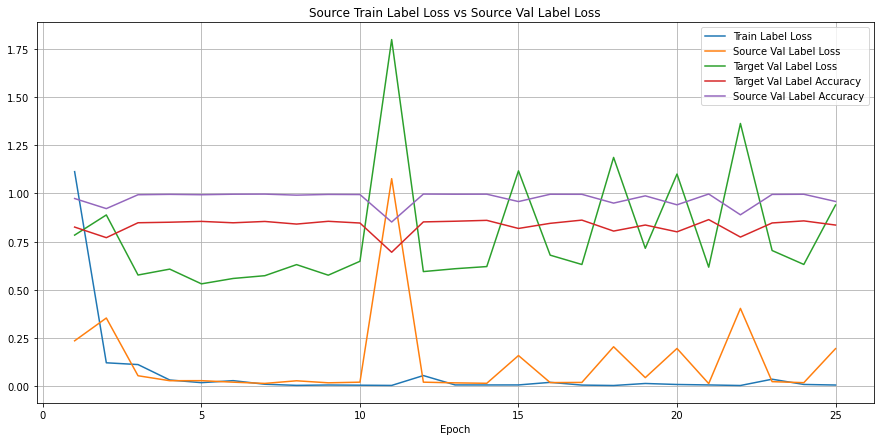

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

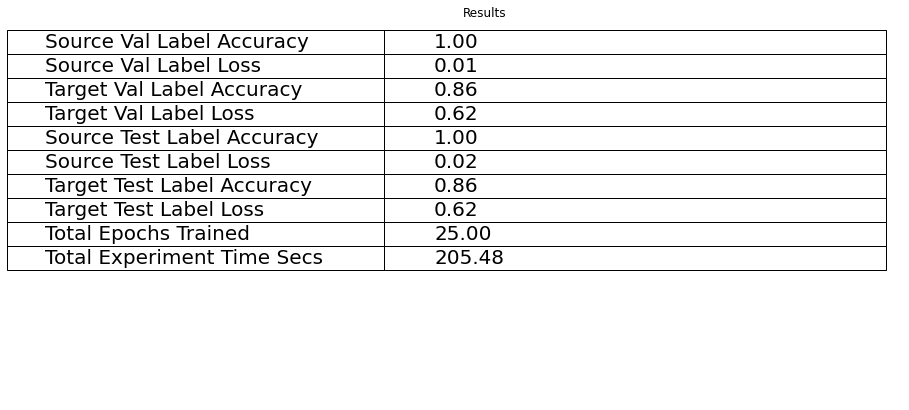

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

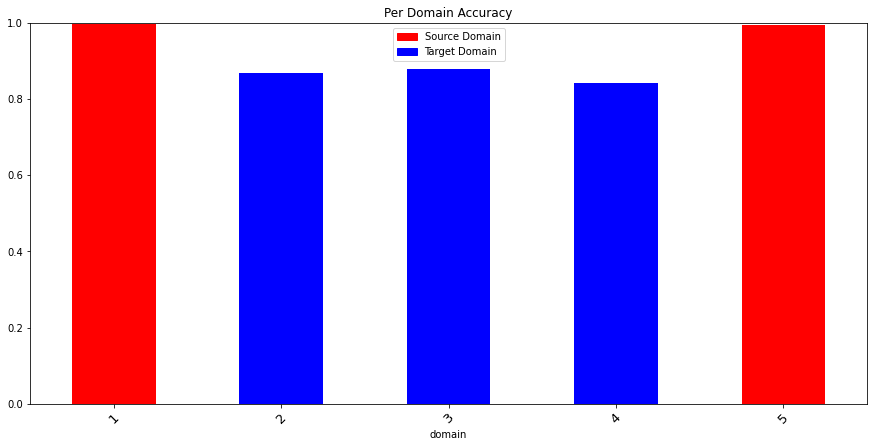

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9959795788130185 Target Test Label Accuracy: 0.8631266045129037
Source Val Label Accuracy: 0.997162937649107 Target Val Label Accuracy: 0.8643735763097949


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_1:cores", "parameters": {"experiment_name": "cnn_1:cores", "device": "cuda", "lr": 0.0001, "labels": ["1-10.", "1-11.", "1-15.", "1-16.", "1-17.", "1-18.", "1-19.", "10-4.", "10-7.", "11-1.", "11-14.", "11-17.", "11-20.", "11-7.", "13-20.", "13-8.", "14-10.", "14-11.", "14-14.", "14-7.", "15-1.", "15-20.", "16-1.", "16-16.", "17-10.", "17-11.", "17-2.", "19-1.", "19-16.", "19-19.", "19-20.", "19-3.", "2-10.", "2-11.", "2-17.", "2-18.", "2-20.", "2-3.", "2-4.", "2-5.", "2-6.", "2-7.", "2-8.", "3-13.", "3-18.", "3-3.", "4-1.", "4-10.", "4-11.", "4-19.", "5-5.", "6-15.", "7-10.", "7-14.", "8-18.", "8-20.", "8-3.", "8-8."], "batch_size": 128, "domains_source": [1, 5], "domains_target": [2, 3, 4], "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"